In [14]:
from binance.client import Client
import os
import json
from binance import ThreadedWebsocketManager
import numpy as np
import pandas as pd
from talib.abstract import EMA

In [15]:
with open('../config/key.json') as j:
    keys = json.load(j)

In [16]:
client = Client(keys['api_key'], keys['api_secret'])
dict_data = {'error':False}
bsm = ThreadedWebsocketManager()

In [17]:
plot_low = []
plot_hight = []

In [18]:
debugl = None
debugh = None

In [19]:
debugl

In [20]:
def buyORsell(ema_low,ema_hight):
#     buy 100>200
    plot_low.append(ema_low[-1])
    plot_hight.append(ema_hight[-1])
    if ema_low[-1]>ema_hight[-1]:
        return 0 #False
#     sell 100<200
    elif ema_low[-1]<ema_hight[-1]:
        return 1 #True

    return 3

In [21]:
plot_low

[]

In [22]:
data = {
    "price_buy":[],
    "price_sell":[],
    "p_open":0,
    "status":True,
    "sell":0,
    "sw":False,
    "first":True,
    "symbol":"ETHBUSD",
    "starttime": "30 day ago UTC",
    "interval":"1m",
    "low_span":100,
    "hight_span":200
}

print('init get data')
bars = client.get_historical_klines(data["symbol"], data["interval"], data["starttime"])
bars = [line[4] for line in bars]
df = pd.DataFrame(bars, columns=['close'])
print('finish get data')

def btc_trade_history(msg):
    global data,bsm,df

    if data['status'] != True:
        bsm.stop()
        
    if msg['e'] != 'error':
#         calculate
        if data['first']:
            data['first'] = False
            data['p_open'] = msg['k']['o']
            print('p_open:',data['p_open'])
        else:
            if float(msg['k']['o']) != float(data['p_open']):
                # state change 
                print('state change:',data['p_open'])
                df = df.iloc[1: , :]
                df2 = pd.DataFrame([msg['k']["o"]],columns=['close'])
                df = pd.concat([df, df2], ignore_index = True, axis = 0)
                
        if float(msg['k']['o']) != float(data['p_open']) or data['first']:
            # calculate EMA100 and EMA200
            print('df:',df)
            low_df = EMA(df['close'],data['low_span'])
            hight_df = EMA(df['close'],data['hight_span'])
            sORb = buyORsell(low_df, hight_df)

            # sell
            if data['sw']:
                # check price sell>buy
                if sORb:
                    if float(msg['k']['o']) > float(data["price_buy"][-1]):
                        # order_sell = client.order_market_sell(symbol=data['symbol'],quantity=round(float(sell_price),4))
                        # print('order_sell:',order_sell)
                        data["price_sell"].append(msg['k']['o'])
                        # save price sell
                        data['price'] = msg['k']['o']
                        print('sell:',data['price'])
                        # change status sw to False
                        data['sw'] = False
            # buy
            else:
                if not sORb:
                    # order_buy = client.order_market_buy(symbol=data['symbol'],quantity=buy_coin)
                    data["price_buy"].append(msg['k']['o'])
                    print('buy:',msg['k']['o'])
                    # data["price"] = float(msg['k']['c'])
                    data['sw'] = True
                    
            # change value
            data['p_open'] = msg['k']['o']
            print('changed:',data['p_open'])
                    
        dict_data['error'] = False
    else:
        dict_data['error'] = True

init get data
finish get data


In [27]:
import matplotlib.pyplot as plt

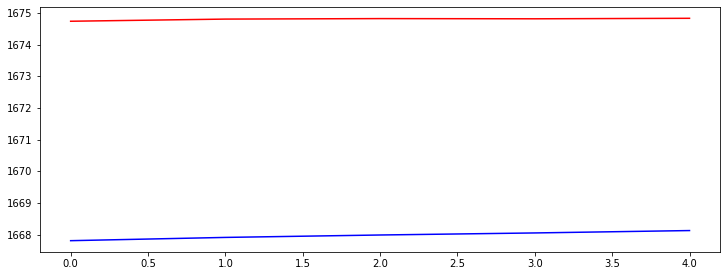

In [32]:
plt.figure(figsize=(12.2, 4.5))
plt.plot(plot_low, color= 'red')
plt.plot(plot_hight, color= 'blue')
# plt.xticks(rotation=45)
# plt.legend(loc='upper left')
plt.show()

In [23]:
bsm.start()
print('starting ...... ')
# bsm.start_symbol_ticker_socket(callback=btc_trade_history, symbol=data["symbol"])
bsm.start_kline_futures_socket(callback=btc_trade_history, symbol=data["symbol"],interval="1m")
# bsm.start_kline_socket(callback= btc_trade_history,symbol=data["symbol"])

starting ...... 


'ethbusd_perpetual@continuousKline_1m'

p_open: 1677.68
state change: 1677.68
df:                close
0      1529.44000000
1      1530.20000000
2      1530.30000000
3      1529.01000000
4      1530.48000000
...              ...
43196  1680.56000000
43197  1679.68000000
43198  1678.74000000
43199  1678.74000000
43200        1677.25

[43201 rows x 1 columns]
ema_low: [          nan           nan           nan ... 1674.60933369 1674.69112906
 1674.74179977]
len ema_low: 43201
ema_hight: [          nan           nan           nan ... 1667.59973315 1667.71058158
 1667.80550117]
len ema_hight: 43201
buy: 1677.25
changed: 1677.25
state change: 1677.25
df:                close
0      1530.20000000
1      1530.30000000
2      1529.01000000
3      1530.48000000
4      1529.33000000
...              ...
43196  1679.68000000
43197  1678.74000000
43198  1678.74000000
43199        1677.25
43200        1678.18

[43201 rows x 1 columns]
ema_low: [          nan           nan           nan ... 1674.69112906 1674.74179977
 1674.80988294]
len 

In [35]:
bsm.stop()

In [33]:
plot_low

[1674.741799770511,
 1674.8098829433723,
 1674.8253308058797,
 1674.8190866315058,
 1674.834946302169]

In [34]:
plot_hight

[1667.8055011669537,
 1667.9087300110637,
 1667.9851605582173,
 1668.0500843337575,
 1668.1254068777002]